In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#zipping data - will take around 5 minutes
folder = '/content/drive/MyDrive/ANPR/character_dataset/'
data='Training Data'

!(cd "{folder}" && zip -r -q data.zip "{data}")

In [7]:
#copying zip file and unzipping in colab
zip_path='/content/drive/MyDrive/ANPR/character_dataset/data.zip'

!cp "{zip_path}" .
!unzip -q data.zip
!rm data.zip

In [36]:
#****************Data augmentation**************#

import albumentations as A
import cv2
PATH='/content/Training Data'

import os

#listing all sub directories
class_dirs=os.listdir(PATH)


def augment(img,path,img_name):
    
    transforms=[
        [A.Blur(blur_limit=(3,3),p=1)],#blur 1
        [A.Blur(blur_limit=(5,5),p=1)],#blur 2
        [A.Rotate(limit=(0,15),p=1)],#rotate the image clockwise
        [A.Rotate(limit=(-15,0),p=1)],#rotate the image anti-clockwise
        [A.Blur(blur_limit=(3,3),p=1),A.Rotate(limit=(-15,0),p=1)],#rotate anti-clockwise and blurr
        [A.Blur(blur_limit=(3,3),p=1),A.Rotate(limit=(0,15),p=1)],#rotate clockwise and blurr
    ]
    
    
    for i,t in enumerate(transforms):
        
        #defining transformation
        transform=A.Compose(t)
        
        #applying transformation
        aug_img=transform(image=img)['image']
        
        #augmented image name
        aug_img_name=f'{path}/{img_name}_aug_{i}.jpg'
        
        #saving file
        cv2.imwrite(aug_img_name,np.float32(aug_img))

        
#iterating over all directories
for d in class_dirs:
    
    #listing all images in sub directory
    files=os.listdir(os.path.join(PATH,d))
    
    #iterating over all images
    for file in files:
        
        #reading image
        img=cv2.imread(os.path.join(PATH,d,file))
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        img_name=file.split('.')[0]
        
        #apply data augmentation
        augment(img,os.path.join(PATH,d),img_name)

    print(f'{d} augmented, number of images: ',len(os.listdir(os.path.join(PATH,d))))
        
print("Data Augmentation Done!")
        
def delete_augmentations():
    #iterating over all directories
    for d in class_dirs:

        #listing all images in sub directory
        files=os.listdir(os.path.join(PATH,d))

        #iterating over all images
        for file in files:
            file_path=os.path.join(PATH,d,file)
            if "aug" in file:
                os.remove(file_path)
                
                

5 augmented, number of images:  168
class_K augmented, number of images:  168
class_E augmented, number of images:  168
class_A augmented, number of images:  168
class_H augmented, number of images:  168
class_W augmented, number of images:  168
1 augmented, number of images:  168
class_Q augmented, number of images:  168
class_V augmented, number of images:  168
class_R augmented, number of images:  168
7 augmented, number of images:  168
class_C augmented, number of images:  168
class_M augmented, number of images:  175
class_X augmented, number of images:  168
class_I augmented, number of images:  168
class_T augmented, number of images:  168
3 augmented, number of images:  168
class_Y augmented, number of images:  168
class_Z augmented, number of images:  168
class_F augmented, number of images:  168
class_O augmented, number of images:  168
0 augmented, number of images:  168
6 augmented, number of images:  168
class_P augmented, number of images:  168
class_D augmented, number of

In [ ]:
#***************************DANGER**************************#
#****************For deleting augmentations*****************#

delete_augmentations()
print("Augmented data deleted")

In [37]:
from itertools import chain


X=[]
Y=[]

#iterating over all directories
for d in class_dirs:
    
    #listing all images in sub directory
    files=os.listdir(os.path.join(PATH,d))
    
    #iterating over all images
    for file in files:
        
        #reading image
        img=cv2.imread(os.path.join(PATH,d,file))
        
        #binarizing image
        img_gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_bw=cv2.threshold(img_gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)[1]
        
        #flattening image and appending it
        X.append(list(chain.from_iterable(img_bw)))
        
        #appending label
        Y.append(file.split('_')[1])
        
print(len(Y))

6055


In [38]:
print(f"no of images: {len(X)}")
print(f"no of dimensions: {len(X[0])}")

no of images: 6055
no of dimensions: 784


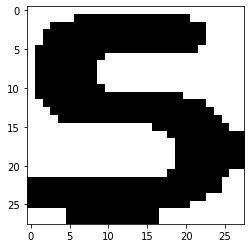

In [39]:
x0=np.reshape(X[0],(-1,28))
plt.imshow(x0, cmap="gray")

In [40]:
#converting to numpy array
X=np.array(X)

#normalising X
X=X/255

#reshaping to (28,28,1)
X=X.reshape(len(X),28,28,1)

In [41]:
from keras.utils import np_utils


#converting Y[i] to int values: 0-9 and 10-35(A-Z)
for i in range(0,len(Y)):
    if Y[i].isalpha():
        Y[i]=ord(Y[i])-ord('A')+10
    else:
        Y[i]=int(Y[i])

#one hot encoding
Y=np_utils.to_categorical(Y,36)

#converting to numpy array
Y=np.array(Y)

In [42]:
print(X.shape)
print(Y.shape)

(6055, 28, 28, 1)
(6055, 36)


In [43]:
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D

In [49]:
width=28
height=28
batch_size=64
epochs=30
model=Sequential()
#Conv Layer-1
model.add(Conv2D(6,kernel_size=5,input_shape=(width,height,1),data_format='channels_last',padding='same',activation='relu'))

#Max Pool Layer-1
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

#Conv Layer-2
model.add(Conv2D(16,kernel_size=5,activation='relu'))

#Max Pool Layer-2
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

#Conv Layer-3
model.add(Conv2D(120,kernel_size=5,activation='relu'))
model.add(Flatten())

#Fully Connected Layer-1
model.add(Dense(84,activation='relu'))

#Softmax
model.add(Dense(36,activation='softmax'))

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 1, 120)         48120     
_________________________________________________________________
flatten_2 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 84)               

In [51]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [52]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=99)

print(X_train.shape)
print(X_test.shape)

(4541, 28, 28, 1)
(1514, 28, 28, 1)


In [53]:
history=model.fit(X_train,Y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_test,Y_test))

Epoch 1/30
71/71 [==============================] - 33s 11ms/step - loss: 3.0703 - accuracy: 0.2186 - val_loss: 0.4538 - val_accuracy: 0.8573
Epoch 2/30
71/71 [==============================] - 0s 5ms/step - loss: 0.3229 - accuracy: 0.9098 - val_loss: 0.1258 - val_accuracy: 0.9683
Epoch 3/30
71/71 [==============================] - 0s 5ms/step - loss: 0.1065 - accuracy: 0.9684 - val_loss: 0.1182 - val_accuracy: 0.9577
Epoch 4/30
71/71 [==============================] - 0s 5ms/step - loss: 0.0690 - accuracy: 0.9791 - val_loss: 0.0780 - val_accuracy: 0.9795
Epoch 5/30
71/71 [==============================] - 0s 5ms/step - loss: 0.0637 - accuracy: 0.9775 - val_loss: 0.0685 - val_accuracy: 0.9802
Epoch 6/30
71/71 [==============================] - 0s 5ms/step - loss: 0.0706 - accuracy: 0.9717 - val_loss: 0.0593 - val_accuracy: 0.9749
Epoch 7/30
71/71 [==============================] - 0s 5ms/step - loss: 0.0427 - accuracy: 0.9818 - val_loss: 0.0569 - val_accuracy: 0.9789
Epoch 8/30
71/71 [

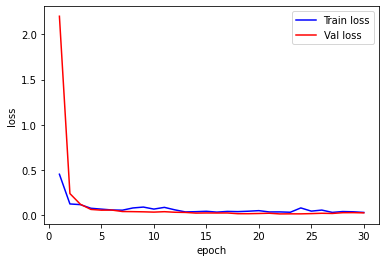

In [55]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

x=list(range(1,epochs+1))

vy=history.history['val_loss']
ty=history.history['loss']

def plt_dynamic(x,y,y_1,ax,colors=['b']):
    ax.plot(x,y,'b',label='Train loss')
    ax.plot(x,y_1,'r',label='Val loss')
    plt.legend()
    fig.canvas.draw()
plt_dynamic(x,vy,ty,ax)

In [56]:
model.save('char_recog_model.h5')

In [57]:
def to_label(n):
    if n<=9:
        return str(n)
    
    return chr(n-10+ord('A'))

In [58]:
pred=model.predict(np.array([X_test[200]]))[0]

# Generate arg maxes for prediction
actual=np.argmax(Y_test[200])
pred = np.argmax(pred)

print(f"actual: {to_label(actual)}")
print(f"pred: {to_label(pred)}")

actual: 2
pred: 2
